In [1]:
import pandas as pd; import numpy as np; import matplotlib as mtpl; import matplotlib.pyplot as plt;import time;import timeit
font = {'family' : 'serif',
        'weight' : 'ultralight',
        'size'   : 14}

mtpl.rc('font', **font)

### Haar esta en ky, plot log-log, es el que utilizo en adelante
### Haar_S1 esta en y, plot lin-log, solo para comparar con matlab!

In [18]:
def Smooth121(x):
    signal = x
    length = len(signal)
    output = np.zeros(length-2)
    coef= np.array([1,2,1])
    for i in range(length - 2):
        output[i]= np.sum(signal[i:i+3] * coef / 4)
    return output

def Haar(ix,smooth=False,plot=False,start=False,final=False):
    #global lis
    if start==0 and final==0:
        x=np.array(lis[ix][lis[ix].columns[1]]);t=np.array(lis[ix][lis[ix].columns[0]])
    if start==0 and final!=0:
        x=np.array(lis[ix][lis[ix].columns[1]])[:final];t=np.array(lis[ix][lis[ix].columns[0]])[:final]
    if start!=0 and final!=0:
        x=np.array(lis[ix][lis[ix].columns[1]])[start:final];t=np.array(lis[ix][lis[ix].columns[0]])[start:final]

    #Cálculo deltas
    deltas_t=[];epsilons=[]
    for i in range(1,int(len(t)/2)+1):  #steps: i from 1 to n/2 
        deltas_t.append(t[i:]-t[:-i]) #0= Delta_t1, 1= Delta_t2, ..., [n/2]-1 = Delta_tn/2
    for i in range(1,len(deltas_t)+1): #for all my deltas_t (all steps-differences, de 1 en 1, de 2 en 2, etc)
        epsilons.append(deltas_t[i-1][:-i]/(deltas_t[i-1][:-i]+deltas_t[i-1][i:]))
    x=x[:-1];t=t[:-1]
    
    #Cálculo fluctuaciones
    Hs=[]; delta_t=[]; ep_min=0.25; ep_max=1-ep_min; calib=2; counter=0
    for H in range(2,len(x)-1,2):
        for start in range(len(x)-H-1):
            int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])
            int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
            counter+=1
            if ep_min<epsilons[int(H/2)-1][start] and epsilons[int(H/2)-1][start]<ep_max:
                #Hs.append(calib*abs(int2-int1)) #S_1
                Hs.append((calib*(int2-int1))**2) #S_2 (falta despues sacar raíz)
                delta_t.append(deltas_t[int(H/2)-1][start]+deltas_t[int(H/2)-1][start+int(H/2)]) #No logaritmicos           

    print(counter-len(Hs),' fluctuaciones eliminadas (',(counter-len(Hs))/counter*100,'%)')
    
    #Paso a dataframes
    data_df=pd.DataFrame(data={'delta t':delta_t , 'Hs': Hs}); data_sorted=data_df.sort_values('delta t',axis=0).reset_index(drop=True)

    max_t=max(np.log10(data_sorted['delta t'])); min_t=min(np.log10(data_sorted['delta t']))
    n_bins=int(((max_t)-(min_t))*20); rango_int=(max_t-min_t)/n_bins; time=np.array([]); ave_values=np.array([]); upper=np.array([]); lower=np.array([]);

    for i in range(n_bins):
        interval=data_sorted[(i*rango_int+min_t<=np.log10(data_sorted['delta t']))&(np.log10(data_sorted['delta t'])<min_t+(i+1)*rango_int)]
        time=np.append(time,((i*rango_int+min_t)+((i+1)*rango_int+min_t))/2)
        ave_values=np.append(ave_values,np.sqrt(interval.mean()[1]))        ## Tomo el sqrt del <[2*(x1-x2)]^2> ...

    if smooth==False:
        smooth_val=ave_values
    if smooth==True:
        smooth_val=Smooth121(ave_values)
        time=time[1:-1]
    
    val_mask = np.isfinite(smooth_val)
    time=time[val_mask]
    smooth_val=smooth_val[val_mask]
    
    if plot==True:
        plt.subplots(figsize=(15, 7))
        plt.title(id_data['Name'][ix]+' non-uniform full set Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
        for i in range(n_bins):
            plt.axvline(x = i*rango_int+min_t,linestyle='-.',linewidth=0.5)
        plt.plot(time,np.log10(smooth_val),'.-',color='black',linewidth=2,label='Log binning')
        plt.legend()
        plt.show()
    #Scater plot
        #plt.subplots(figsize=(15, 7))
        #plt.plot(np.log10(data_sorted['delta t']),np.log10(np.sqrt(data_sorted['Hs'])),'.',label='S2')
        #plt.title(id_data['Name'][ix]+' scatter full set Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
        #plt.show()
    #Histograms
        #plt.subplots(figsize=(15, 7))
        #plt.hist(x=delta_t, bins='auto', color='#7DC2B7',alpha=0.7, rwidth=0.85)
        #plt.xlabel('\u0394 t (Ky)',fontsize=20); plt.ylabel('Frequency',fontsize=20)
        #plt.title(id_data['Name'][ix]+' \u0394 t evaluated histogram')
        #plt.show()

    return time,np.log10(smooth_val)


In [112]:
dust_file='Dust records corregidos Completo.xlsx'
#dust_file='Dust records corregidos Completo Uniformes.xlsx'
#dust_file='EDC_DustFlux_25yr.xlsx'

#dust_file='Temps records corregidos Completo.xlsx'

id_columns=['Name','Data id','Latitud','Longitud','Age units','Data units','Data length']
id_data=pd.read_excel(dust_file,sheet_name=0,usecols=id_columns)
df_data=pd.read_excel(dust_file,sheet_name=1,skiprows=1)#skip row 1 o 0

#SEPARAR COLUMNAS
columns=df_data.size/len(df_data) ;lis=[];new_length=np.array([])

for i in range(int(columns)):
    if (i+1)%2==1: 
        dupla=df_data[[df_data.columns[i],df_data.columns[i+1]]].dropna() 
        dupla.index=[j for j in range(0, len(dupla))] 
        lis.append(dupla)
        new_length=np.append(new_length,np.shape(dupla)[0])
id_data

,Name,Data id,Latitud,Longitud,Age units,Data units,Data length
0,Vostok,1,-78.464167,106.865833,ka,(ug/m2/a),507
1,EPICA Dome C,2,-75.100000,123.350000,ka,(mg/m**2/a),298205
2,EPICA EDML,3,-75.002500,0.068400,ka,(ug/m**2/a),2303
3,Talos Dome,4,-72.817000,159.183000,ka BP,(µg/kg),64998
4,PS75/59-2,5,-54.215000,-125.425500,(kyr),(wt-%),2384
5,ML1208-17PC,6,0.480000,-156.450000,ka,(g/m2/yr),192
6,ML1208-31BB,7,4.680000,-160.050000,ka,(g/m2/yr),254
7,ML1208-37BB,8,7.040000,-161.630000,ka,(g/m2/yr),105
8,Xifeng,9,35.700000,107.600000,ka,(g/m^2/ka),722
9,Chinese Loess Plateau,10,35.760000,107.817333,ka,(g/cm3/ka),1801


In [115]:
ix=3
x=np.array([]);t=np.array([])
for i in range(0,len(lis[ix][lis[ix].columns[1]]),99):
    x=np.append(x,lis[ix][lis[ix].columns[1]][i]*1000)
    t=np.append(t,lis[ix][lis[ix].columns[0]][i]*1000)

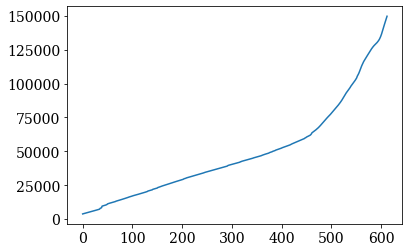

In [116]:
plt.plot(t)

In [114]:
298205/99

3012.1717171717173

In [117]:
def Haar_S1(ix,y1,y2,plot=False):    
    x=np.array([]);t=np.array([])
    for i in range(0,len(lis[ix][lis[ix].columns[1]]),99):
        x=np.append(x,lis[ix][lis[ix].columns[1]][i])
        t=np.append(t,lis[ix][lis[ix].columns[0]][i]*1000)
    
    #x=np.array(lis[ix][lis[ix].columns[1]]);t=np.array(lis[ix][lis[ix].columns[0]])*1000 #lo paso a years
    
    #Cálculo deltas
    deltas_t=[];epsilons=[]
    for i in range(1,int(len(t)/2)+1):  #steps: i from 1 to n/2 
        deltas_t.append(t[i:]-t[:-i]) #0= Delta_t1, 1= Delta_t2, ..., [n/2]-1 = Delta_tn/2
    for i in range(1,len(deltas_t)+1): #for all my deltas_t (all steps-differences, de 1 en 1, de 2 en 2, etc)
        epsilons.append(deltas_t[i-1][:-i]/(deltas_t[i-1][:-i]+deltas_t[i-1][i:]))
    x=x[:-1];t=t[:-1]
    
    #Cálculo fluctuaciones
    Hs=[]; delta_t=[]; ep_min=0.25; ep_max=1-ep_min; calib=2; counter=0
    for H in range(2,len(x)-1,2):
        for start in range(len(x)-H-1):
            int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])
            int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
            counter+=1
            if ep_min<epsilons[int(H/2)-1][start] and epsilons[int(H/2)-1][start]<ep_max:
                Hs.append(calib*abs(int2-int1)) #S_1                
                delta_t.append(deltas_t[int(H/2)-1][start]+deltas_t[int(H/2)-1][start+int(H/2)]) #No logaritmicos           

    print(counter-len(Hs),' fluctuaciones eliminadas (',(counter-len(Hs))/counter*100,'%)')
    
    #Paso a dataframes
    data_df=pd.DataFrame(data={'delta t':delta_t , 'Hs': Hs}); data_sorted=data_df.sort_values('delta t',axis=0).reset_index(drop=True)

    max_t=max(np.log10(data_sorted['delta t'])); min_t=min(np.log10(data_sorted['delta t']))
    n_bins=int(((max_t)-(min_t))*20); rango_int=(max_t-min_t)/n_bins; time=np.array([]); ave_values=np.array([]);# upper=[]; lower=[];

    for i in range(n_bins):
        interval=data_sorted[(i*rango_int+min_t<=np.log10(data_sorted['delta t']))&(np.log10(data_sorted['delta t'])<min_t+(i+1)*rango_int)]
        time=np.append(time,((i*rango_int+min_t)+((i+1)*rango_int+min_t))/2)
        ave_values=np.append(ave_values,(interval.mean()[1]))        ## ya no tomo el sqrt del <[2*(x1-x2)]^2>, por que no esta al ^2 ...

    #smooth_val=ave_values  
    smooth_val=Smooth121(ave_values)
    time=time[1:-1]
    
    val_mask = np.isfinite(smooth_val)
    time=time[val_mask]
    smooth_val=smooth_val[val_mask]
    
    if plot=='plot':
        plt.subplots(figsize=(15, 7))
        plt.title(id_data['Name'][ix]+' non-uniform full set Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('S\u2081(\u0394 t)',fontsize=18)
        for i in range(n_bins):
            plt.axvline(x = i*rango_int+min_t,linestyle='-.',linewidth=0.5)
        #plt.plot(time[1:-1],(smooth_val),'.-',color='black',linewidth=2,label='Log binning')
        plt.plot(time,smooth_val,'.-',color='black',linewidth=2,label='Log binning')
        plt.xlim([1.5,6])
        plt.ylim([y1,y2])
        plt.legend()
        plt.show()
    #Scater plot
        #plt.subplots(figsize=(15, 7))
        #plt.plot(np.log10(data_sorted['delta t']),np.log10(np.sqrt(data_sorted['Hs'])),'.',label='S2')
        #plt.title(id_data['Name'][ix]+' scatter full set Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
        #plt.show()
    #Histograms
        #plt.subplots(figsize=(15, 7))
        #plt.hist(x=delta_t, bins='auto', color='#7DC2B7',alpha=0.7, rwidth=0.85)
        #plt.xlabel('\u0394 t (Ky)',fontsize=20); plt.ylabel('Frequency',fontsize=20)
        #plt.title(id_data['Name'][ix]+' \u0394 t evaluated histogram')
        #plt.show()

    return time,np.log10(smooth_val)

In [ ]:
Vostok
ix=0
y1=1000
y2=5000

EDML
ix=2
y1=30
y2=100

PS75
ix=4
y1=0
y2=18

#17PC
ix=5
y1=0.02
y2=0.14

#31BB
ix=6
y1=0
y2=0.14

#37BB
ix=7
y1=0.03 
y2=0.19 

xifeng
ix=8
y1=0.7*10**5 
y2=2*10**5

RECAP
ix=10
y1=100 
y2=1900

GRIP
ix=11
y1=10 
y2=290

NGRIP
ix=12
y1=500
y2=3000

In [51]:
ix=10 #el 1 ,el 4 y el 7 avoid
y1=500
y2=3000
[time,val]=Haar_S1(ix,y1,y2)
#[time2,val2]=Haar(ix,smooth=True,plot=True,start=False,final=False)

0  fluctuaciones eliminadas ( 0.0 %)


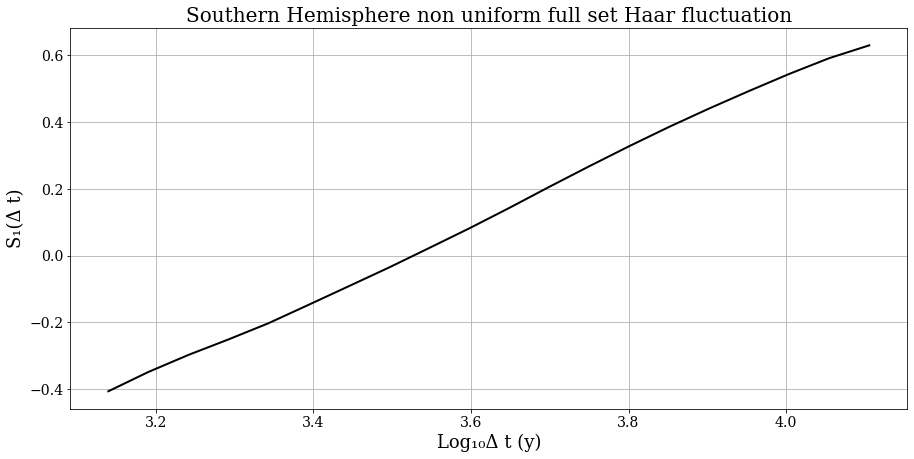

In [53]:
plt.subplots(figsize=(15, 7))
plt.title(id_data['Name'][ix]+' non uniform full set Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (y)',fontsize=18);plt.ylabel('S\u2081(\u0394 t)',fontsize=18)
plt.plot(time,val,'-',color='black',linewidth=2,label='Log binning')
#plt.xticks([-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75])
plt.grid()
#plt.xlim([-1,2])
#plt.ylim([y1,y2])
plt.show()

In [44]:
10**0.7

5.011872336272722

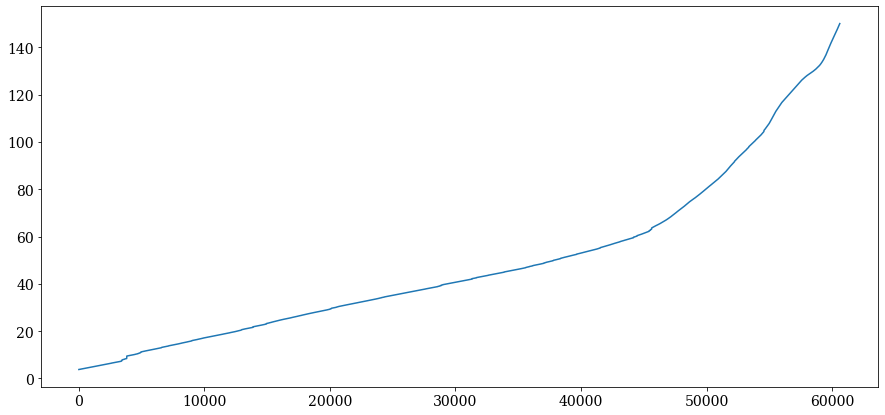

In [34]:
plt.subplots(figsize=(15, 7))
#plt.plot(lis[9][lis[9].columns[0]],lis[9][lis[9].columns[1]])
plt.plot(lis[3][lis[3].columns[0]])

plt.show()

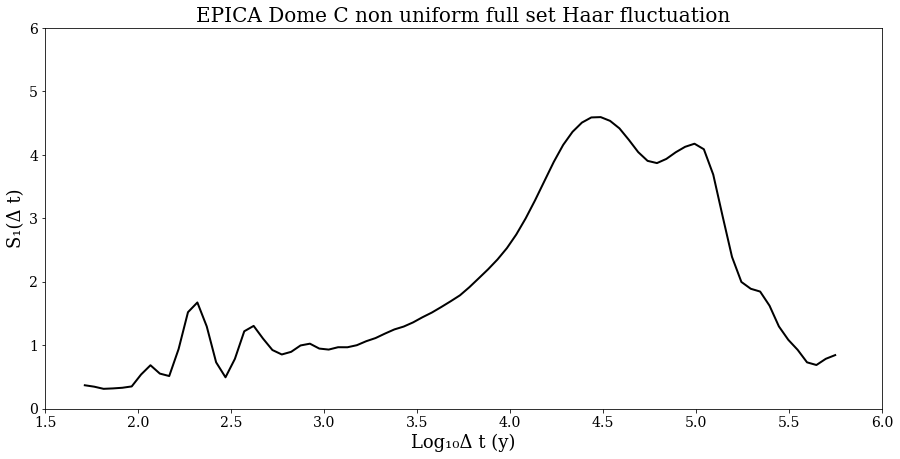

In [119]:
ix=1
y1=0
y2=6
#[time,val]=Haar_S1(ix,y1,y2)

plt.subplots(figsize=(15, 7))
plt.title(id_data['Name'][ix]+' non uniform full set Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (y)',fontsize=18);plt.ylabel('S\u2081(\u0394 t)',fontsize=18)
plt.plot(time,10**val,'-',color='black',linewidth=2,label='Log binning')
plt.xlim([1.5,6])
plt.ylim([y1,y2])
#plt.legend()


##Cambiar los uniform por no uniform!
if ix!=4:
    plt.savefig('11-'+str(ix+1)+' '+id_data['Name'][ix]+' Haar 50 binning NU.jpg',bbox_inches='tight')

if ix==4:
    plt.savefig('11-5 PS7559 Haar 50 binning NU.jpg',bbox_inches='tight')    

plt.show()

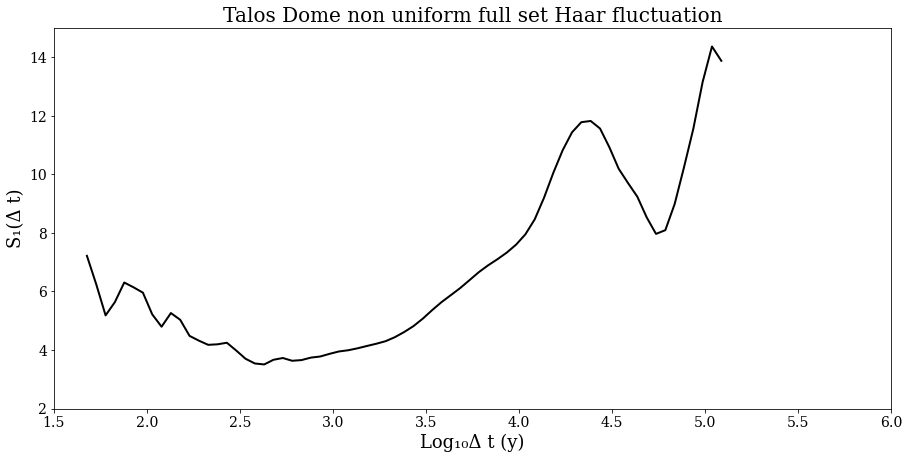

In [107]:
plt.subplots(figsize=(15, 7))
plt.title(id_data['Name'][ix]+' non uniform full set Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (y)',fontsize=18);plt.ylabel('S\u2081(\u0394 t)',fontsize=18)
plt.plot(time,10**val,'-',color='black',linewidth=2,label='Log binning')
plt.xlim([1.5,6])
plt.ylim([2,15])
plt.show()

In [72]:
10**5

100000